## Bayesian GPFA example notebook

In this notebook, we provide a simple bGPFA example.\
See the readme for further details of the code used for the analyses in the paper.\
Note also that mgplvm should be installed for this notebook to run (see readme for details).

We start by loading some packages and setting a couple of parameters

In [2]:
### import the packages needed ###
import mgplvm as mgp #note that our GPLVM library must be installed first
import torch
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.size'] = 20

### set pytorch device and random seeds ###
device = mgp.utils.get_device()
np.random.seed(0)
torch.manual_seed(0)
def detach(tensor):
    return tensor.detach().cpu().numpy()

loading


Next we generate a synthetic dataset, in this case with two 'true' latent dimensions and a negative binomial noise model (c.f. Figure 2c).

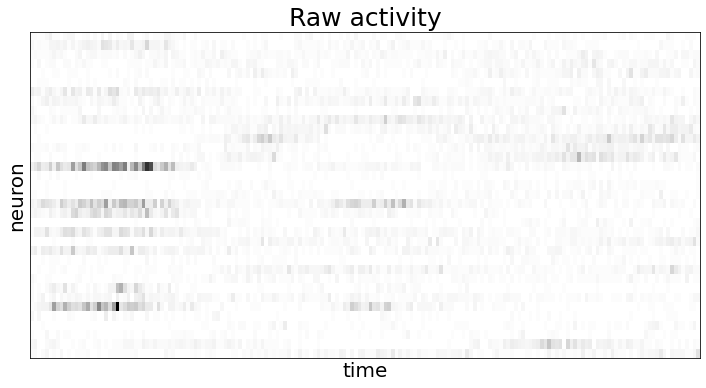

In [3]:
#### generate latents and tuning curves ####
n, T = 35, 180 #35 neurons, 180 time points
ts = np.arange(T) # time points
dts_2 = (ts[:, None] - ts[None, :])**2 # compute dts for the kernel
ell = 20 # effective length scale
d_true = 2 # 2 ground truth dimensions
K = np.exp(-dts_2/(2*ell**2)) # TxT covariance matrix
L = np.linalg.cholesky(K + np.eye(T)*1e-6) # TxT cholesky factor
xs = (L @ np.random.normal(0, 1, (T, d_true))).T # DxT true latent states
C = np.random.normal(0, 1, (n, d_true))*0.5 # factor matrix
F = C @ xs # n x T true de-noised activity

#### draw noise from NegBinomial model ####
c_nb = -1.50 #scale factor for reasonable magnitude of activity
p_nb = np.exp(F+c_nb)/(1+np.exp(F+c_nb)) #probability of failure (c.f. appendix)
r_nb = np.random.uniform(1, 10, n) # number of failures (overdispersion paramer; c.f. appendix)
#numpy defines in terms of #successes so we substitute 1 -> 1-p
YNB = np.random.negative_binomial(r_nb, 1-p_nb.T).astype(float).T

### plot the activity we just generated ###
plt.figure(figsize = (12, 6))
plt.imshow(YNB, cmap = 'Greys', aspect = 'auto')
plt.xlabel('time')
plt.ylabel('neuron')
plt.title('Raw activity', fontsize = 25)
plt.xticks([])
plt.yticks([])
plt.show()

We now proceed to instantiate our model

In [4]:
def cb_ard(mod, i, loss):
    """here we construct an (optional) function that helps us keep track of the training"""
    if i % 100 == 0:
        ls, ss = detach(mod.obs.dim_scale).flatten()**(-1), np.mean(detach(mod.lat_dist.scale), axis = (0, -1))
        ms = np.sqrt(np.mean(detach(mod.lat_dist.nu)**2, axis = (0, -1)))
        args = np.argsort(ls)
        #print q(F) scale parameters, q(X) psi parameters, and q(X) nu parameters (c.f. section 2.2)
        print('\n', np.round(ls[args], 2), '', np.round(ss[args], 2), '', np.round(ms[args], 2))
    return False

Y = YNB[None, ...] # we add a trial dimension which isn't actually used here but could be if we had multiple trials
data = torch.tensor(Y).to(device) # put the data on our GPU/CPU
fit_ts = torch.tensor(ts)[None, None, :].to(device) # put our time points on GPU/CPU

d_fit = 2 #lets fit up to 10 latent dimensions (in theory this could just be the number of neurons if we don't have any prior to start from)
lik = mgp.likelihoods.NegativeBinomial(n, Y=Y) # we use a negative binomial noise model in this example
manif = mgp.manifolds.Euclid(T, d_fit) # our latent variables live in a Euclidean space
lprior = mgp.lpriors.Null(manif) # here the prior is defined implicitly in our variational distribution, but if we wanted to fit e.g. Factor analysis this would be a Gaussian prior
var_dist = mgp.rdist.GP_circ(manif, T, 1, fit_ts, _scale=1, ell = 20*0.8) # circulant variational posterior
mod = mgp.models.Lvgplvm(n, T, d_fit, 1, var_dist, lprior, lik, Y = Y, learn_scale = False, ard = True, rel_scale = 0.1).to(device) #create ARD model

train_ps = mgp.crossval.training_params(max_steps = 51, n_mc = 10, burnin = 50, lrate = 5e-2, callback = cb_ard) # helper function to specify training parameters
mod_train = mgp.crossval.train_model(mod, data, train_ps) #ready to train our model!

### training will proceed for 2500 iterations (this should take 1-2 minutes on GPU) ###

D:\Anaconda\envs\mgplvm\lib\site-packages\torch\autograd\__init__.py:130: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ..\aten\src\ATen\native\Copy.cpp:162.)
  Variable._execution_engine.run_backward(


iter   0 | elbo -1.908 | kl 0.000 | loss 1.908 | |mu| 0.051 | sig 1.000 | prior_ell 16.000 |scale 0.132 | lik_count 1.806 |
 [ 5.19 13.98]  [1. 1.]  [0.05 0.05]
iter 100 | elbo -1.462 | kl 0.012 | loss 1.473 | |mu| 0.593 | sig 0.937 | prior_ell 15.831 |scale 0.133 | lik_count 2.559 |
 [6.14 9.72]  [0.93 0.94]  [0.45 0.71]


KeyboardInterrupt: 

Now that we've trained the model, we will run some analyses similar to figure 2C-E\
We start by plotting the learned scale parameter to see how many latent dimensions are retained.

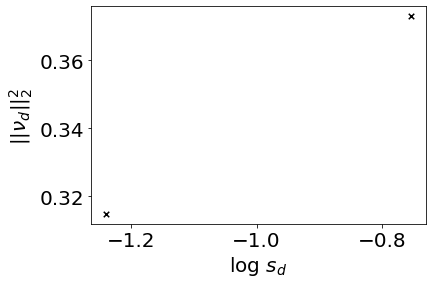

In [4]:
#kernel length scales
_dim_scales = detach(mod.obs.dim_scale).flatten()
dim_scales = np.log(_dim_scales) #take the log of the prior scales
#average 'nu' over trials, time points
nus = np.sqrt(np.mean(detach(mod.lat_dist.nu)**2, axis = (0, -1)))
plt.figure()
plt.scatter(dim_scales, nus, c = 'k', marker = 'x', s = 30)
plt.xlabel(r'$\log \, s_d$')
plt.ylabel(r'$||\nu_d||^2_2$', labelpad = 5)
plt.show()

We see from the above that bGPFA does indeed recover a two-dimensional latent space in this case.\
Now let's see how the resulting latent trajectories compare to our ground truth!

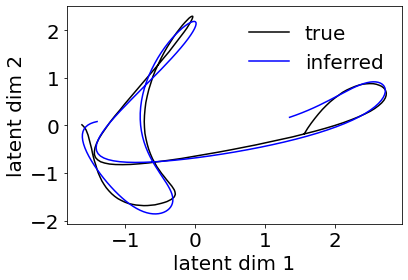

In [5]:
lats = detach(mod.lat_dist.lat_mu)[0, ...] #extract inferred latents
lats = lats[..., np.argsort(-dim_scales)[:2]] #only consider the two most informative dimensions (c.f. appendix)
true_lats = xs.T # T x 2

# here we will align the latent trajectories using linear regression since our model is only specified up to a rotation
lats = lats - np.mean(lats, axis = 0, keepdims = True) #zero-center
true_lats = true_lats - np.mean(true_lats, axis = 0, keepdims = True) #zero-center
T = np.linalg.inv(lats.T @ lats) @ lats.T @ true_lats #regress onto ground truth latents (xs)
lats = lats @ T  #aligned values

plt.figure()
plt.plot(true_lats[:, 0], true_lats[:, 1], 'k-') #plot ground truth
plt.plot(lats[:, 0], lats[:, 1], 'b-') #plot inferred
plt.xlabel('latent dim 1')
plt.ylabel('latent dim 2')
plt.legend(['true', 'inferred'], frameon = False)
plt.show()

Okay it seems like we're doing a fairly reasonable job of recovering the ground truth latents so that's encouraging!\
Finally let's see if our noise model managed to capture the single-neuron overdispersion parameters so we can distinguish 'shared' and 'independent' noise.

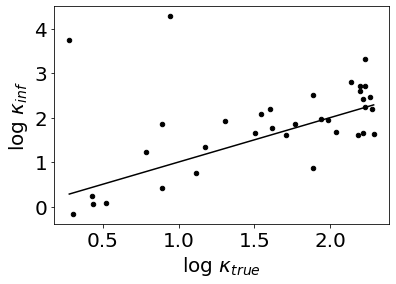

In [6]:
r_inf = detach(mod.obs.likelihood.prms[0]) #inferred overdispersion parameter


plt.figure()
plt.scatter(np.log(r_nb), np.log(r_inf), c = 'k', s = 20) #plot true vs inferred
id_line = np.log(np.array([np.amin(r_nb), np.amax(r_nb)])) #plot identity line for reference
plt.plot(id_line, id_line, 'k-')
plt.xlabel(r'$\log \, \kappa_{true}$')
plt.ylabel(r'$\log \, \kappa_{inf}$')
plt.show()

A few of the neurons are hard to identify (generally the ones with very low firing rates), but on the whole we seem to go a pretty good job capturing the shared vs. independent noise!

We hope that this simple notebook has illustrated the relative ease of fitting and analyzing these models, and importantly it's just as easy for much larger datasets -- it just takes a bit longer!